![dvd_image](dvd_image.jpg)

A DVD rental company needs your help! They want to figure out how many days a customer will rent a DVD for based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which yeilds a MSE of 3 or less on a test set. The model you make will help the company become more efficient inventory planning.

The data they provided is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minutes.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convinience, the reference dummy has already been dropped.

In [1]:
# Import all required libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# Define a global random seed.
RANDOM_SEED = 9

# Set the seed for Python's random module, NumPy.
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [2]:
# Load the rental data from a CSV file.
rental_df = pd.read_csv("rental_info.csv")

# Display the first few rows of the dataset for inspection.
print("First 5 rows of the dataset:", end="\n\n")
display(rental_df.head(5))

# Display the shape of the dataset (rows, columns).
print(f"\nDataset shape: {rental_df.shape}", end="\n\n")

First 5 rows of the dataset:



,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401



Dataset shape: (15861, 15)



**1. Exploratory Data Analysis**

In [3]:
# Basic dataset information: summary of columns, non-null counts, and data types
print("Dataset information:", end="\n\n")
rental_df.info()

Dataset information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rental_date       15861 non-null  object 
 1   return_date       15861 non-null  object 
 2   amount            15861 non-null  float64
 3   release_year      15861 non-null  float64
 4   rental_rate       15861 non-null  float64
 5   length            15861 non-null  float64
 6   replacement_cost  15861 non-null  float64
 7   special_features  15861 non-null  object 
 8   NC-17             15861 non-null  int64  
 9   PG                15861 non-null  int64  
 10  PG-13             15861 non-null  int64  
 11  R                 15861 non-null  int64  
 12  amount_2          15861 non-null  float64
 13  length_2          15861 non-null  float64
 14  rental_rate_2     15861 non-null  float64
dtypes: float64(8), int64(4), object(3)
memory usage: 1.8+ MB


In [4]:
# Display the number of unique values in each column.
print("Unique values per column:", end="\n\n")
print(rental_df.nunique())

Unique values per column:

rental_date         15813
return_date         15836
amount                 12
release_year            7
rental_rate             3
length                140
replacement_cost       21
special_features       15
NC-17                   2
PG                      2
PG-13                   2
R                       2
amount_2               12
length_2              140
rental_rate_2           3
dtype: int64


In [5]:
# Display basic statistical description of numeric features.
print("Descriptive statistics for numeric features:", end="\n\n")
rental_df.describe()

Descriptive statistics for numeric features:



,amount,release_year,rental_rate,length,replacement_cost,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
count,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000
mean,4.217161,2006.885379,2.944101,114.994578,20.224727,0.204842,0.200303,0.223378,0.198726,23.355504,14832.841876,11.389287
std,2.360383,2.025027,1.649766,40.114715,6.083784,0.403599,0.400239,0.416523,0.399054,23.503164,9393.431996,10.005293
min,0.990000,2004.000000,0.990000,46.000000,9.990000,0.000000,0.000000,0.000000,0.000000,0.980100,2116.000000,0.980100
25%,2.990000,2005.000000,0.990000,81.000000,14.990000,0.000000,0.000000,0.000000,0.000000,8.940100,6561.000000,0.980100
50%,3.990000,2007.000000,2.990000,114.000000,20.990000,0.000000,0.000000,0.000000,0.000000,15.920100,12996.000000,8.940100
75%,4.990000,2009.000000,4.990000,148.000000,25.990000,0.000000,0.000000,0.000000,0.000000,24.900100,21904.000000,24.900100
max,11.990000,2010.000000,4.990000,185.000000,29.990000,1.000000,1.000000,1.000000,1.000000,143.760100,34225.000000,24.900100


In [6]:
# Display the count of missing values for each column in the DataFrame.
print("Missing values in the dataset:", end="\n\n")
print(rental_df.isna().sum())

Missing values in the dataset:

rental_date         0
return_date         0
amount              0
release_year        0
rental_rate         0
length              0
replacement_cost    0
special_features    0
NC-17               0
PG                  0
PG-13               0
R                   0
amount_2            0
length_2            0
rental_rate_2       0
dtype: int64


In [7]:
# Function to detect outliers using the IQR method.
def detect_outliers(column: str):
    """
    Detect outliers in a numeric column using the IQR method.

    Parameters:
        column (str): Name of the column to analyze.

    Returns:
        tuple: (number of outliers, lower bound, upper bound)
    """
    Q1 = rental_df[column].quantile(0.25)  # First quartile (25th percentile)
    Q3 = rental_df[column].quantile(0.75)  # Third quartile (75th percentile)
    IQR = Q3 - Q1  # Interquartile range
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = rental_df[(rental_df[column] < lower_bound) | (rental_df[column] > upper_bound)]
    return outliers.shape[0], lower_bound, upper_bound

# Detect outliers for all numeric columns.
metrics = rental_df.select_dtypes(include=[np.number]).columns
outlier_analysis = {metric: detect_outliers(metric) for metric in metrics}

# Display outlier counts and bounds for each metric.
print("Outlier analysis:", end="\n\n")
for metric, (count, lower, upper) in outlier_analysis.items():
  print(f"{metric:<20}: {count:<10} outliers (Lower Bound: {lower:.2f}, Upper Bound: {upper:.2f})")

Outlier analysis:

amount              : 855        outliers (Lower Bound: -0.01, Upper Bound: 7.99)
release_year        : 0          outliers (Lower Bound: 1999.00, Upper Bound: 2015.00)
rental_rate         : 0          outliers (Lower Bound: -5.01, Upper Bound: 10.99)
length              : 0          outliers (Lower Bound: -19.50, Upper Bound: 248.50)
replacement_cost    : 0          outliers (Lower Bound: -1.51, Upper Bound: 42.49)
NC-17               : 3249       outliers (Lower Bound: 0.00, Upper Bound: 0.00)
PG                  : 3177       outliers (Lower Bound: 0.00, Upper Bound: 0.00)
PG-13               : 3543       outliers (Lower Bound: 0.00, Upper Bound: 0.00)
R                   : 3152       outliers (Lower Bound: 0.00, Upper Bound: 0.00)
amount_2            : 2644       outliers (Lower Bound: -15.00, Upper Bound: 48.84)
length_2            : 0          outliers (Lower Bound: -16453.50, Upper Bound: 44918.50)
rental_rate_2       : 0          outliers (Lower Bound: -34.90,

**2) Data Preprocessing**

In [8]:
# Remove duplicate rows to avoid redundant information.
rental_df.drop_duplicates(inplace=True)
print("Shape after removing duplicates:", rental_df.shape)

Shape after removing duplicates: (15861, 15)


In [9]:
# Convert date columns to datetime.
rental_df["return_date"] = pd.to_datetime(rental_df["return_date"])
rental_df["rental_date"] = pd.to_datetime(rental_df["rental_date"])

# Calculate rental length in days as a new feature.
rental_df["rental_length"] = rental_df["return_date"] - rental_df["rental_date"]
rental_df["rental_length_days"] = rental_df["rental_length"].dt.days

In [10]:
# Sort and display value counts for 'special_features'.
print("Special features value counts:", end="\n\n")
print(rental_df["special_features"].value_counts().sort_values())

Special features value counts:

special_features
{Trailers,"Deleted Scenes","Behind the Scenes"}                  772
{Trailers,Commentaries,"Deleted Scenes"}                         916
{Trailers,Commentaries,"Deleted Scenes","Behind the Scenes"}     983
{Commentaries,"Deleted Scenes"}                                 1011
{"Deleted Scenes"}                                              1023
{"Deleted Scenes","Behind the Scenes"}                          1035
{Trailers,"Deleted Scenes"}                                     1047
{Commentaries,"Behind the Scenes"}                              1078
{Commentaries}                                                  1089
{Commentaries,"Deleted Scenes","Behind the Scenes"}             1101
{"Behind the Scenes"}                                           1108
{Trailers,"Behind the Scenes"}                                  1122
{Trailers,Commentaries}                                         1129
{Trailers}                                            

In [11]:
# Create binary features from 'special_features' column.
rental_df["deleted_scenes"] = np.where(rental_df["special_features"].str.contains("Deleted Scenes", na=False), 1, 0)
rental_df["behind_the_scenes"] = np.where(rental_df["special_features"].str.contains("Behind the Scenes", na=False), 1, 0)

In [12]:
# Define columns that may leak target information and drop them.
leakage_columns = ["rental_date", "return_date", "special_features", "rental_length"]

# Define features (X) and target (y).
X = rental_df.drop(leakage_columns + ["rental_length_days"], axis=1)
y = rental_df["rental_length_days"]

In [13]:
# Split the dataset into training and testing sets with a fixed random state for reproducibility.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,    # 20% of the data goes into the test set.
    random_state=RANDOM_SEED,  # Ensure reproducibility.
)

# Display shapes of the resulting datasets for verification.
print(f"Training Features Shape: {X_train.shape}")
print(f"Test Features Shape:     {X_test.shape}")
print(f"Training Target Shape:   {y_train.shape}")
print(f"Test Target Shape:       {y_test.shape}")

Training Features Shape: (12688, 14)
Test Features Shape:     (3173, 14)
Training Target Shape:   (12688,)
Test Target Shape:       (3173,)


In [14]:
# Define the columns to scale.
columns_to_scale = ["amount", "release_year", "rental_rate", "length", "replacement_cost", "amount_2", "length_2", "rental_rate_2"]

# Initialize the StandardScaler.
scaler = StandardScaler()

# Scale only the specified columns.
X_train_scaled = X_train.copy()  # Create a copy to retain the original structure.
X_test_scaled = X_test.copy()

# Fit the scaler on the selected columns of X_train and transform.
X_train_scaled[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])

# Transform the selected columns of X_test using the same scaler.
X_test_scaled[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

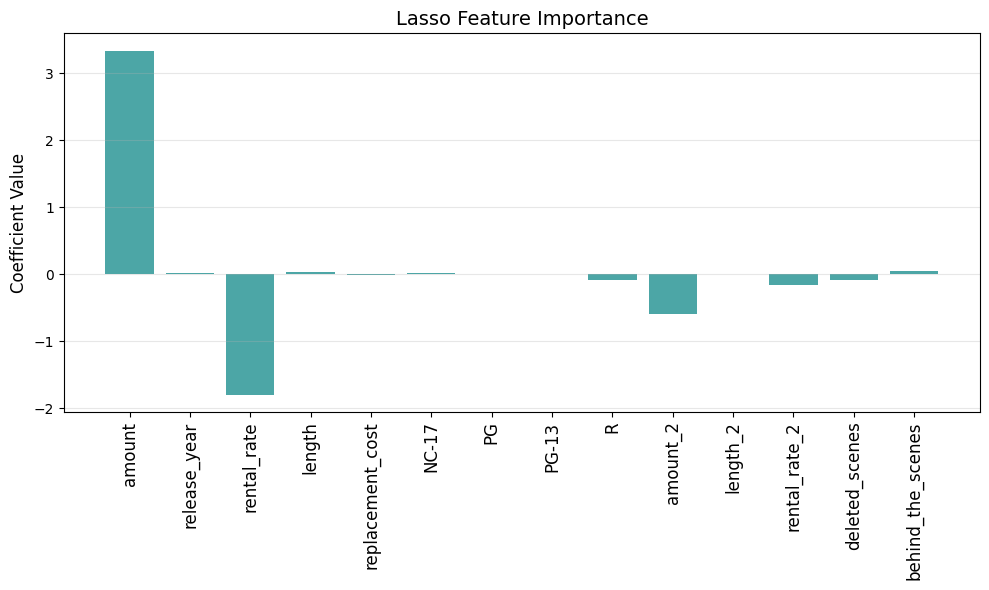

Selected features by Lasso: ['amount', 'release_year', 'length', 'NC-17', 'PG-13', 'behind_the_scenes']


In [15]:
# Perform feature selection with Lasso.
lasso = Lasso(alpha=0.01, random_state=RANDOM_SEED)
lasso_coef = lasso.fit(X_train_scaled, y_train).coef_

# Display Lasso feature importance.
plt.figure(figsize=(10, 6))
plt.bar(X_train_scaled.columns, lasso_coef, color="teal", alpha=0.7)
plt.xticks(rotation=90, fontsize=12)
plt.title("Lasso Feature Importance", fontsize=14)
plt.ylabel("Coefficient Value", fontsize=12)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Select features with positive coefficients from Lasso.
selected_features = X_train_scaled.columns[lasso_coef > 0]
print("Selected features by Lasso:", selected_features.tolist())
X_train_lasso = X_train_scaled[selected_features]
X_test_lasso = X_test_scaled[selected_features]

**3. Model Training and Evaluation**

In [16]:
# Define regression models.
regression_models = {
    "KNeighborsRegressor": KNeighborsRegressor(),
    "RandomForestRegressor": RandomForestRegressor(random_state=RANDOM_SEED),
    "SVR": SVR(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=RANDOM_SEED),
    "LinearRegression": LinearRegression(),
}

In [17]:
# Initialize a dictionary to store results.
model_scores = {}

# Iterate over the classifier models.
print("="*100)
for model_name, model in regression_models.items():
    print(f"Model: {model_name}")

    # Perform 5-Fold cross-validation.
    kf = KFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)
    cv_scores = -1 * cross_val_score(model, X_train_lasso, y_train, cv=kf, scoring="neg_mean_squared_error")
    model_scores[model_name] = np.mean(cv_scores)

    # Print cross-validation results.
    print(f"{model_name}: Average MSE = {np.mean(cv_scores):.4f}")
    print(f"{model_name}: Average RMSE = {np.sqrt(np.mean(cv_scores)):.4f}")
    print("="*100)

# Store the mean cross-validation score for each model.
mean_scores = list(model_scores.values())

# Find the index of the model with the lowest mean MSE.
best_model_index = mean_scores.index(min(mean_scores))

# Retrieve the corresponding model name.
best_model_name = list(model_scores.keys())[best_model_index]

# Print the best model.
print(f"\nBest Regression Model: {best_model_name} with Average MSE = {mean_scores[best_model_index]:.4f}", end="\n\n")
print("="*100)

Model: KNeighborsRegressor
KNeighborsRegressor: Average MSE = 3.3264
KNeighborsRegressor: Average RMSE = 1.8239
Model: RandomForestRegressor
RandomForestRegressor: Average MSE = 2.5132
RandomForestRegressor: Average RMSE = 1.5853
Model: SVR
SVR: Average MSE = 4.5502
SVR: Average RMSE = 2.1331
Model: DecisionTreeRegressor
DecisionTreeRegressor: Average MSE = 2.6908
DecisionTreeRegressor: Average RMSE = 1.6404
Model: LinearRegression
LinearRegression: Average MSE = 4.8279
LinearRegression: Average RMSE = 2.1972

Best Regression Model: RandomForestRegressor with Average MSE = 2.5132



In [18]:
# Get the best regression model.
best_model = regression_models[best_model_name]

# Define hyperparameter grids for the best model based on its type to enable optimized grid search.
if best_model_name == "KNeighborsRegressor":
    param_grid = {
        "n_neighbors": [3, 5, 7, 10, 15, 20, 25],
        "weights": ["uniform", "distance"],
        "p": [1, 2, 3]
    }
elif best_model_name == "RandomForestRegressor":
    param_grid = {
        "n_estimators": np.arange(10, 200, 10),
        "max_depth": np.arange(5, 50, 5),
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 5, 10]
    }
elif best_model_name == "SVR":
    param_grid = {
        "C": [0.1, 1, 10, 100, 1000],
        "kernel": ["linear", "rbf", "poly"],
        "gamma": ["scale", "auto"]
    }
elif best_model_name == "DecisionTreeRegressor":
    param_grid = {
        "max_depth": [None, 10, 20, 30, 50],
        "min_samples_split": [2, 5, 10, 20],
        "min_samples_leaf": [1, 2, 5, 10]
    }
elif best_model_name == "LinearRegression":
    param_grid = {}  # LinearRegression has no critical hyperparameters for grid search.

In [19]:
# Perform grid search on the best model.
grid_search = RandomizedSearchCV(best_model, param_grid, cv=kf, n_iter=50, scoring="neg_mean_squared_error", verbose=0, n_jobs=-1, random_state=RANDOM_SEED)
# grid_search = GridSearchCV(best_model, param_grid, cv=kf, scoring="neg_mean_squared_error", verbose=0, n_jobs=-1)
grid_search.fit(X_train_lasso, y_train)

# Display the best hyperparameters and CV score.
print("="*100)
print(f"Best parameters for {best_model_name}: {grid_search.best_params_}")
print(f"Best cross-validated MSE: {(-grid_search.best_score_):.4f}")
print(f"Best cross-validated RMSE: {np.sqrt(-grid_search.best_score_):.4f}")

# Evaluate the best model on the test set.
final_model = grid_search.best_estimator_
y_pred = final_model.predict(X_test_lasso)

# Calculate test performance metrics.
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
print("="*100)
print(f"Test MSE for the best model ({best_model_name}): {test_mse:.4f}")
print(f"Test RMSE for the best model ({best_model_name}): {test_rmse:.4f}")
print("="*100)

Best parameters for RandomForestRegressor: {'n_estimators': 130, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 40}
Best cross-validated MSE: 2.5107
Best cross-validated RMSE: 1.5845
Test MSE for the best model (RandomForestRegressor): 2.3646
Test RMSE for the best model (RandomForestRegressor): 1.5377


In [20]:
# Create a DataFrame to compare actual and predicted values.
comparison_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred
})

# Display general statistics for the actual and predicted values.
print("Summary statistics for actual and predicted values:", end="\n\n")
display(comparison_df.describe())

Summary Statistics for Actual and Predicted Values:



,Actual,Predicted
count,3173.000000,3173.000000
mean,4.509928,4.475481
std,2.664922,2.219149
min,0.000000,0.204673
25%,2.000000,2.686559
50%,5.000000,3.769908
75%,7.000000,6.589703
max,9.000000,8.978462
